<a href="https://colab.research.google.com/github/imran9891/TensorFlow/blob/main/05_transfer_learning_in_tensorflow_part_2_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 2: Fine-Tuning
In the previous notebook, we covered transfer learning feature extraction, now it's time to learn about a new kind of transfer learning: fine-tuning.

In [1]:
# Check if we're using a GPU?
!nvidia-smi

Wed Jul 28 14:11:28 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     7W /  75W |      0MiB /  7611MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions

In previous notebooks, we've created a bunch of helper functions, now we could rewrite them all, however, this is tedious.

So, it's a good idea to put functions you'll want to use again in a script you can download and import into your notebooks (or elsewhere).

We have done this for some of the functions we've used previously here: https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-07-28 14:11:42--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-07-28 14:11:42 (61.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import helper functions we're going to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

> **Note:** If you're runnign this notebook in Google Colab, when it times out Colab will delete `helper_functions.py` so you'll have to redownload it if you want access to your helper functions.

## Let's get some data

This time we're going to see how we can use the pretrained models within `tf.keras.applications` and apply them to our own problem (recognizing images of food).

Link: https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [4]:
# Get 10% of training data of 10 classes of Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2021-07-28 14:11:54--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.70.128, 74.125.132.128, 74.125.69.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.70.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   148MB/s    in 1.1s    

2021-07-28 14:11:55 (148 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [5]:
# Check out how many images and sub-directories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [6]:
# Create training and test directory paths
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [7]:
import tensorflow as tf
IMAGE_SIZE = (224,224)
BATCH_SIZE = 32
print("Training data:")
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMAGE_SIZE,
                                                                            batch_size=BATCH_SIZE,
                                                                            label_mode='categorical')
print("Testing data:")
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory = test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMAGE_SIZE,
                                                                batch_size=BATCH_SIZE)

Training data:
Found 750 files belonging to 10 classes.
Testing data:
Found 2500 files belonging to 10 classes.


In [8]:
# Check out the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [9]:
# See an example of a batch of data
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[1.06357140e+02 5.43571434e+01 5.83571434e+01]
   [1.05071426e+02 5.30714264e+01 5.70714264e+01]
   [1.03285713e+02 5.32857132e+01 5.58571396e+01]
   ...
   [1.65846893e+02 1.83418365e+02 1.83418365e+02]
   [1.66642868e+02 1.84642868e+02 1.84642868e+02]
   [1.67897980e+02 1.87897980e+02 1.86897980e+02]]

  [[1.08882652e+02 5.38826523e+01 5.88826523e+01]
   [1.05209183e+02 5.29948997e+01 5.70663261e+01]
   [1.01071426e+02 5.09591827e+01 5.40153046e+01]
   ...
   [1.64974487e+02 1.82545959e+02 1.82331696e+02]
   [1.68214294e+02 1.86214294e+02 1.86214294e+02]
   [1.66734650e+02 1.86734650e+02 1.87734650e+02]]

  [[1.02576530e+02 5.53520393e+01 5.80000000e+01]
   [9.98979568e+01 5.52142868e+01 5.81836739e+01]
   [9.69030609e+01 5.43826523e+01 5.90000000e+01]
   ...
   [1.67020447e+02 1.84591919e+02 1.84377655e+02]
   [1.64729584e+02 1.82729584e+02 1.83158157e+02]
   [1.68352173e+02 1.88352173e+02 1.89352173e+02]]

  ...

  [[1.61637756e+02 9.22805557e+01 6.06629086e+00]
   [1

## Model 0: Building a transfer learning feature extraction model using the Keras Functional API

The Sequential API is straight-forward, it runs our layers in sequential order.

But the functional API gives us more flexibility with our models.

Link: https://www/tensorflow.org/guide/keras/functional

<img src = "C:/Users/Hp/Desktop/Python/Udemy/TensorFlow/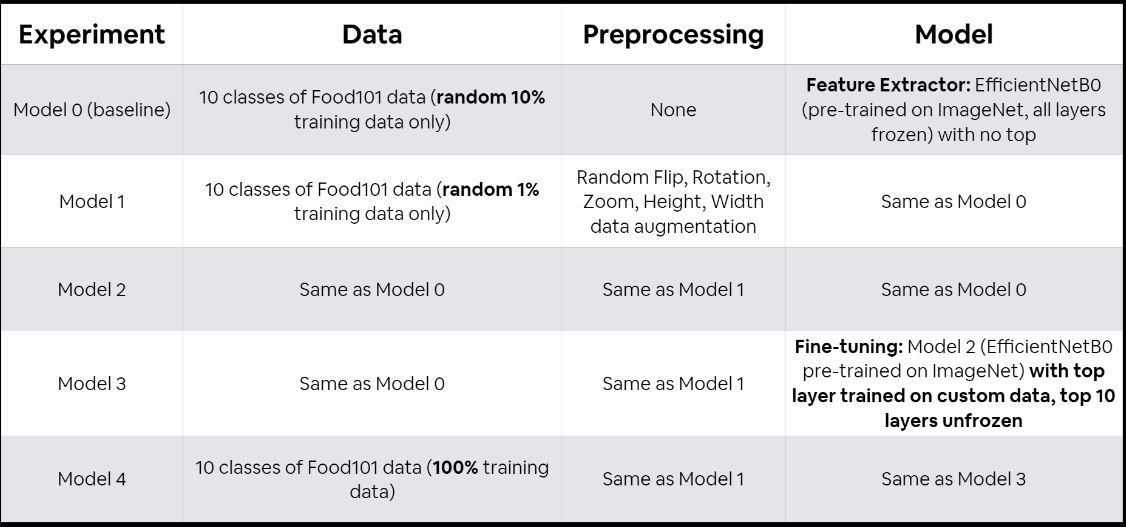Experiments.png"

In [10]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the underlying pre-trained patterns aren't updated during training)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224,224,3),name="input_layer")

# 4. If using a model like ResNet50V2 you will need to normalize inputs (you don't have to for EfficentNet(s))
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base model
x = base_model(inputs)
print(f"Shape after passing inputs through base_model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs and the outputs into a model
model_0 = tf.keras.Model(inputs,outputs)

# 9. Compile the model
model_0.compile(
    loss = "categorical_crossentropy",
    optimizer = tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

# 10. Fit the model and save its history
history_0 = model_0.fit(train_data_10_percent,
                        epochs=5,
                        steps_per_epoch=len(train_data_10_percent),
                        validation_data=test_data,
                        validation_steps=int(0.25 * len(test_data)),
                        callbacks=[create_tensorboard_callback(dir_name="TensorBoard",
                                                              experiment_name="BaseModel")])

16711680/16705208 [==============================] - 0s 0us/step
Shape after passing inputs through base_model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: TensorBoard/BaseModel/20210728-141740
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 44s 435ms/step - loss: 1.9235 - accuracy: 0.3973 - val_loss: 1.3540 - val_accuracy: 0.7039
Epoch 2/5
24/24 [==============================] - 8s 346ms/step - loss: 1.1534 - accuracy: 0.7520 - val_loss: 0.9341 - val_accuracy: 0.7944
Epoch 3/5
24/24 [==============================] - 6s 257ms/step - loss: 0.8417 - accuracy: 0.8067 - val_loss: 0.7447 - val_accuracy: 0.8289
Epoch 4/5
24/24 [==============================] - 7s 261ms/step - loss: 0.6825 - accuracy: 0.8387 - val_loss: 0.6638 - val_accuracy: 0.8257
Epoch 5/5
24/24 [==============================] - 7s 261ms/step - loss: 0.5873 - accuracy: 0.8640 - val_loss: 0.6093 - val_accuracy: 0.8503


In [11]:
# Evaluate on the full test dataset
model_0.evaluate(test_data)

79/79 [==============================] - 11s 139ms/step - loss: 0.6085 - accuracy: 0.8492


[0.6085479259490967, 0.8492000102996826]

In [12]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

In [13]:
# How about we get a summary of the base model?
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, None, None, 3 7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization[0][0]              
_____________________________________________________________________________________

In [14]:
# How about a summary of our whole model?
model_0.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


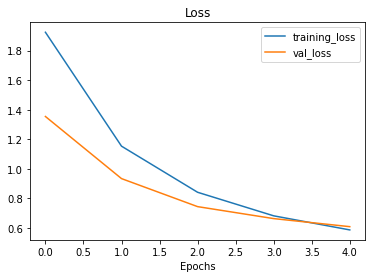

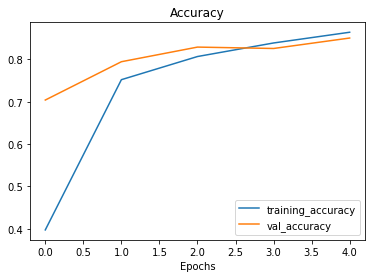

In [15]:
# Check out our model's training curves
plot_loss_curves(history_0)

## Getting a feature vector from a trained model

Let's demonstrate the Global Average Pooling 2D layer...

We have a tensor after our model goes through `base_model` of shape (None, 7, 7, 1280).

But then when it passes through `GlobalAveragePooling2D`, it turns into (None, 1280).

Let's use a similar shaped tensor of (1, 4, 4, 3) and then pass it to GlobalAveragePooling2D.

**Conversion from 4D tensor to 2D tensor.**

In [16]:
# Define the input shape
input_shape = (1,4,4,3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(shape=input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Pass the random tensor through a GlobalAveragePooling2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

# Check the shape of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of Global Average Pooled 2D tensor : {global_average_pooled_tensor.shape}" )

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor: (1, 4, 4, 3)
Shape of Global Average Pooled 2D tensor : (1, 3)


In [17]:
# Let's replicate the Global Average Pooled 2D layer
tf.reduce_mean(input_tensor, axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

**Practise:** Try to do the same with the above two cells but this time use `GlobalMaxPool2D`...and see what happens.

**Note:** One of the reasons feature extraction transfer learning is named how it is because what often happens is pretrained model outputs a feature vector (a long tensor of numbers which represents the learned representation of the model on a particular sample, in our case, this is the output of the tf.keras.layers.GlobalAveragePooling2D() layer) which can then used to extract patterns out of for our own specific problem.

In [18]:
global_max_pooled_tensor = tf.keras.layers.GlobalMaxPool2D()(input_tensor)
print(f" Global Max Pooled 2D tensor:\n {global_max_pooled_tensor}")


 Global Max Pooled 2D tensor:
 [[0.9058464 1.1603122 1.6994323]]


## Running a series of transfer learning experiments

We've seen the incredible results transfer learning can get with only 10% of the training data, but how does it go with 1% of the training data...
How about we set up a bunch of experiments to find out:
0. `model_0`: use feature extraction transfer learning with 10% of the training data with no data augmentation (baseline_model)✔
1. `model_1`: use feature extraction transfer learning with 1% of the training data with data augmentation
2. `model_2`: use feature extraction transfer learning with 10% of the training data with data augmentation
3. `model_3`: use fine tuning transfer learning on 10% of the training data with data augmentation
4. `model_4`: use fine tuning transfer learning on 100% of the training data with data augmentation

**Note:** Throughout all experiments the same test dataset will be used to evaluate our model... this ensures consistency accross evaluation metrics.


### Getting and preprocessing data for model_1

In [19]:
# Download and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

unzip_data("10_food_classes_1_percent.zip")

--2021-07-28 14:22:10--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.197.128, 173.194.198.128, 64.233.191.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.197.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   219MB/s    in 0.6s    

2021-07-28 14:22:10 (219 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [20]:
# How many images are we working with?
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'

In [21]:
# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

In [22]:
# Setup data loaders
IMG_SIZE = (224,224)
BATCH_SIZE = 32

print("Training data")
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir_1_percent,
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=BATCH_SIZE,
                                                                           label_mode="categorical")
print("Testing data")
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE,
                                                                label_mode='categorical')

Training data
Found 70 files belonging to 10 classes.
Testing data
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into the model

To add data augmentation right into our models, we can use the layers inside:

* `tf.keras.layers.experimental.preprocessing()`

We can see the benefits of doing this within the TensorFlow Data Augmentation documentation: https://www.tensorflow.org/tutorials/images/data_augmentation#use_keras_preprocessing_layers

Off the top our of heads, after reading the docs, the benefits of using data augmentation inside the model are:

* Preprocessing of images (augmenting them) happens on the GPU (much faster) rather than the CPU.
* Image data augmentation only happens during training, so we can still export our whole model and use it elsewhere.

In [23]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmentation stage with horizontal flipping, rotations, zooms etc
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
  tf.keras.layers.experimental.preprocessing.RandomWidth(0.2)
  # tf.keras.layers.experimental.preprocessing.Rescaling(1./255) # Keep for models like ResNet50V2 byt EfficientNet(s) have built-in rescale
],name="data_augmentation_layer")

### Visualizing our data augmentation layer (and see what happens to our data)

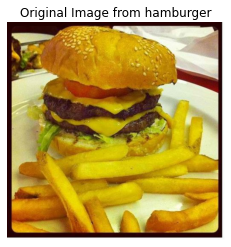

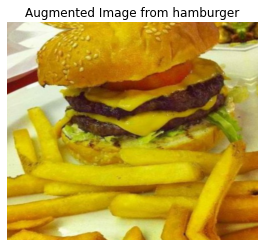

In [28]:
# View a random image and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(os.listdir(train_dir_1_percent))
target_dir = train_dir_1_percent + "/" + target_class
random_img = random.choice(os.listdir(target_dir))
img_path = target_dir + "/" + random_img

# Read and plot in the random image
img = mpimg.imread(img_path)
plt.imshow(img)
plt.axis(False)
plt.title(f"Original Image from {target_class}");

# Now plot our augmented image
aug_img = data_augmentation(tf.expand_dims(img,axis=0))
plt.figure()
plt.imshow(tf.squeeze(aug_img)/255.)
plt.title(f"Augmented Image from {target_class}")
plt.axis(False);

## Model 1: Feature Extraction transfer learning on 1% of the data with data augmentation

In [31]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

# Create the input layer
inputs = tf.keras.layers.Input(shape = input_shape, name='input_layer')

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model the inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool the output features of the base model
x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)

# Put a dense layer on as the output
outputs = tf.keras.layers.Dense(10, activation='softmax', name='output_layer')(x)

# Combine the model
model_1 = tf.keras.Model(inputs,outputs)

# Compile the model
model_1.compile(
    loss = "categorical_crossentropy",
    optimizer = tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_1_percent),
                                validation_data=test_data,
                                validation_steps=int(0.25* len(test_data)),
                                callbacks = create_tensorboard_callback(dir_name="TensorBoard",
                                                                        experiment_name="Model_1"))

Saving TensorBoard log files to: TensorBoard/Model_1/20210728-145359
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


3/3 [==============================] - 18s 5s/step - loss: 2.4532 - accuracy: 0.0286 - val_loss: 2.2772 - val_accuracy: 0.1332
Epoch 2/5
3/3 [==============================] - 6s 3s/step - loss: 2.2168 - accuracy: 0.1571 - val_loss: 2.1523 - val_accuracy: 0.2089
Epoch 3/5
3/3 [==============================] - 6s 3s/step - loss: 1.9797 - accuracy: 0.3857 - val_loss: 2.0596 - val_accuracy: 0.2730
Epoch 4/5
3/3 [==============================] - 5s 2s/step - loss: 1.8531 - accuracy: 0.4714 - val_loss: 1.9599 - val_accuracy: 0.3684
Epoch 5/5
3/3 [==============================] - 5s 2s/step - loss: 1.6480 - accuracy: 0.6714 - val_loss: 1.8776 - val_accuracy: 0.4326


In [32]:
# Check out model summary
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling_3 (Rescaling)         (None, None, None, 3 0           input_4[0][0]                    
__________________________________________________________________________________________________
normalization_3 (Normalization) (None, None, None, 3 7           rescaling_3[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization_3[0][0]            
_____________________________________________________________________________________

In [33]:
for layer_number,layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_4
1 rescaling_3
2 normalization_3
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_d

In [34]:
model_1.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation_layer (Seq (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [35]:
# Evaluate on the full test dataset
model_1.evaluate(test_data)

79/79 [==============================] - 15s 176ms/step - loss: 1.8653 - accuracy: 0.4452


[1.8652867078781128, 0.44519999623298645]

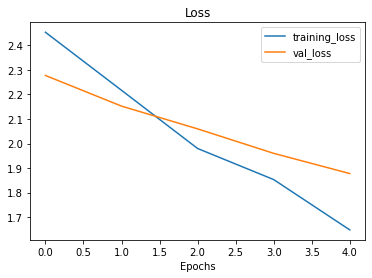

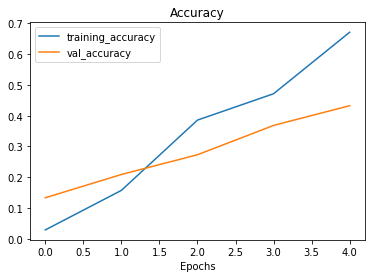

In [36]:
# How do the model with 1% of the data with data augmentation loss curves look?
plot_loss_curves(history_1_percent)

## Model 2: Feature Extraction transfer learning model with 10% of data and data augmentation

The training data here "train_data_10_percent" is already passed with loaders through tf.keras.preprocessing.image_dataset_from_directory and turns into batches of size 32. 

In [45]:
train_data_10_percent

<BatchDataset shapes: ((None, 224, 224, 3), (None, 10)), types: (tf.float32, tf.float32)>

In [51]:
# Making the directory
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"
train_dir,test_dir

('10_food_classes_10_percent/train', '10_food_classes_10_percent/test')

In [50]:
test_data= tf.keras.preprocessing.image_dataset_from_directory(directory = test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE)

Found 2500 files belonging to 10 classes.


In [37]:
# Creating data augmentation layer for 10_percent_data
data_augmentation_10_percent = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
  tf.keras.layers.experimental.preprocessing.RandomWidth(0.2)
],name = 'data_augmentation_10_percent_layer')

In [53]:
## Model Creation

# Setup base_model, freeze the model, and setup the input_shape
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

# Set up input layer
inputs = tf.keras.layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation layer
x = data_augmentation_10_percent(inputs) # inputs gets passed intp data_augmentation layer

# Setup base_model
x = base_model(x, training=False)

# Pooling Layer
x = tf.keras.layers.GlobalAveragePooling2D(name="global_averalge_pooling_layer")(x)

# Output Dense layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name = "output_layer")(x)

# Combining the model
model_2 = tf.keras.Model(inputs, outputs)

# Compiling the model
model_2.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

# Fit the model
history_2_10_percent = model_2.fit(train_data_10_percent,
                                   epochs=5,
                                   steps_per_epoch=len(train_data_10_percent),
                                   validation_data = test_data,
                                   validation_steps = int(0.25*len(test_data)),
                                   callbacks = create_tensorboard_callback(dir_name="TensorBoard",
                                                                           experiment_name="Model_2"))

Saving TensorBoard log files to: TensorBoard/Model_2/20210728-154200
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 27s 762ms/step - loss: 1.9964 - accuracy: 0.3413 - val_loss: 1.4863 - val_accuracy: 0.6579
Epoch 2/5
24/24 [==============================] - 13s 541ms/step - loss: 1.3522 - accuracy: 0.6893 - val_loss: 1.0506 - val_accuracy: 0.7697
Epoch 3/5
24/24 [==============================] - 14s 567ms/step - loss: 1.0568 - accuracy: 0.7600 - val_loss: 0.8443 - val_accuracy: 0.8026
Epoch 4/5
24/24 [==============================] - 13s 514ms/step - loss: 0.9014 - accuracy: 0.7827 - val_loss: 0.7536 - val_accuracy: 0.8076
Epoch 5/5
24/24 [==============================] - 13s 521ms/step - loss: 0.7861 - accuracy: 0.8107 - val_loss: 0.7034 - val_accuracy: 0.8092


In [54]:
# check the summary
model_2.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation_10_percent (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_averalge_pooling_laye (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


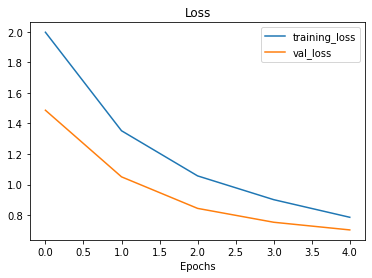

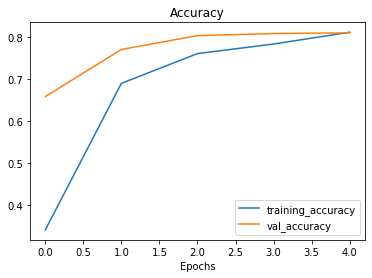

In [55]:
# Check the loss curves
plot_loss_curves(history_2_10_percent)

### Creating a ModelCheckPoint callback

Callbacks are a tool which can `add helpful functionality` to your models during training, evaluation or inference

The ModelCheckpoint callback intermediately saves our model (the full model or just the weights) during training. This is useful so we can come and start where we left off.

In [56]:
# Set checkpoint path
checkpoint_path = "10_percent_model_checkpoint_weights/checkpoint.ckpt"

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         save_freq="epoch", #save every epoch
                                                         verbose=1)
# Fitting the model_2
history_2_10_percent_cb = model_2.fit(train_data_10_percent,
                                      epochs=5,
                                      steps_per_epoch=len(train_data_10_percent),
                                      validation_data=test_data,
                                      validation_steps=len(test_data),
                                      callbacks=[checkpoint_callback])

Epoch 1/5
24/24 [==============================] - 23s 947ms/step - loss: 0.7054 - accuracy: 0.8160 - val_loss: 0.6499 - val_accuracy: 0.8144

Epoch 00001: saving model to 10_percent_model_checkpoint_weights/checkpoint.ckpt
Epoch 2/5
24/24 [==============================] - 23s 945ms/step - loss: 0.6581 - accuracy: 0.8267 - val_loss: 0.6294 - val_accuracy: 0.8144

Epoch 00002: saving model to 10_percent_model_checkpoint_weights/checkpoint.ckpt
Epoch 3/5
24/24 [==============================] - 22s 924ms/step - loss: 0.6175 - accuracy: 0.8333 - val_loss: 0.6042 - val_accuracy: 0.8184

Epoch 00003: saving model to 10_percent_model_checkpoint_weights/checkpoint.ckpt
Epoch 4/5
24/24 [==============================] - 22s 915ms/step - loss: 0.5759 - accuracy: 0.8507 - val_loss: 0.5862 - val_accuracy: 0.8228

Epoch 00004: saving model to 10_percent_model_checkpoint_weights/checkpoint.ckpt
Epoch 5/5
24/24 [==============================] - 23s 936ms/step - loss: 0.5350 - accuracy: 0.8613 - va

In [57]:
# What were model_0 results?
model_0.evaluate(test_data)

79/79 [==============================] - 16s 189ms/step - loss: 0.6085 - accuracy: 0.8492


[0.6085479259490967, 0.8492000102996826]

In [58]:
# Check model_2 results on all data
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 15s 179ms/step - loss: 0.5648 - accuracy: 0.8272


[0.5647730827331543, 0.8271999955177307]

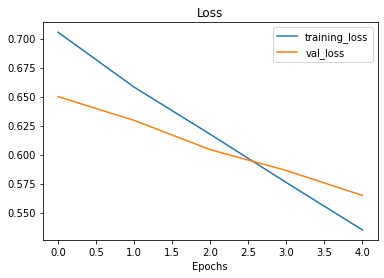

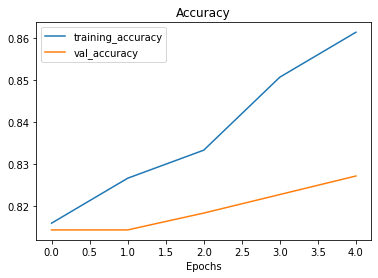

In [59]:
plot_loss_curves(history_2_10_percent_cb)

### Loading in checkpointed weights

Loading in checkpointed weights returns a model to a spicific checkpoint.

In [60]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [61]:
# Evaluate model_2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 16s 190ms/step - loss: 0.5648 - accuracy: 0.8272


In [63]:
# If the results from our previously evaluated model_2 matched the loaded weights, everything has worked!
results_10_percent_data_aug == loaded_weights_model_results

False

In [64]:
results_10_percent_data_aug

[0.5647730827331543, 0.8271999955177307]

In [65]:
loaded_weights_model_results

[0.5647730231285095, 0.8271999955177307]

In [66]:
# Check to see if loaded model results are very close to our previous non-loaded model results
import numpy as np
np.isclose(results_10_percent_data_aug, loaded_weights_model_results)

array([ True,  True])

In [68]:
# Check the difference between the two results
print(np.array(results_10_percent_data_aug) - np.array(loaded_weights_model_results))

[5.96046448e-08 0.00000000e+00]


## Model 3: Fine tuning an existing model on 10% of the data

> **Note:** Fine-tuning usually works best *after* training a feature extraction model for a few epochs with large amounts of custom data.

In [70]:
# Layers in loaded model
model_2.layers

In [72]:
# Are these layers trainable?
for layer in model_2.layers:
  print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fa5a86ea850> True
<tensorflow.python.keras.engine.sequential.Sequential object at 0x7fa52774dd10> True
<tensorflow.python.keras.engine.functional.Functional object at 0x7fa526b570d0> False
<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x7fa526b99c10> True
<tensorflow.python.keras.layers.core.Dense object at 0x7fa526b69150> True


In [77]:
# What layers are in our base_model (EfficientNetB0) and are they trainable?
for i,layer in enumerate(model_2.layers[2].layers):
  print(i,layer.name, layer.trainable)

0 input_6 False
1 rescaling_5 False
2 normalization_5 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [79]:
# How many trainable variables are in our base_model?
print(len(model_2.layers[2].trainable_variables))

0


In [150]:
# To begin fine-tuning, let's start by setting the last 10 layers of our base model.trainable = True
base_model.trainable = True

# Freeze all layers expect for last 10
for layer in model_2.layers[2].layers[:-10]:
  layer.trainable = False

# Recompile (we have to recompile our models every time we make a change)
model_2.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # when fine tuning you typically want to lower the learning rate by 10x.
    metrics=["accuracy"]
)

**Note:** When using fine tuning it's best practise to lower your learning rate by some amount. How much? This is a hyper-parameter you can tune. But a good rule of thumb is atleast 10x (though different sources will claim other values). 

A good resource for information on this is the ULMFit Paper: https://arxiv.org/abs/1801.06146

In [151]:
for i,layer in enumerate(model_2.layers[2].layers[-10:]):
  print(i,layer.name,layer.trainable)

0 block7a_se_squeeze True
1 block7a_se_reshape True
2 block7a_se_reduce True
3 block7a_se_expand True
4 block7a_se_excite True
5 block7a_project_conv True
6 block7a_project_bn True
7 top_conv True
8 top_bn True
9 top_activation True


In [152]:
for i,layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_6 False
1 rescaling_5 False
2 normalization_5 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [158]:
# Now we've unfrozen some of the layers closer to the top, how many trainable variables are there?
print(len(base_model.trainable_variables))
print(len(model_2.trainable_variables))

10
12


In [156]:
for layer in model_2.layers:
  print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fa5a86ea850> True
<tensorflow.python.keras.engine.sequential.Sequential object at 0x7fa52774dd10> True
<tensorflow.python.keras.engine.functional.Functional object at 0x7fa526b570d0> True
<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x7fa526b99c10> True
<tensorflow.python.keras.layers.core.Dense object at 0x7fa526b69150> True


In [163]:
# Refit the model (same as model_2 except with more trainable layers)
history_fine_tune_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                                    epochs = 10,
                                                    steps_per_epoch=len(train_data_10_percent),
                                                    validation_data=test_data,
                                                    validation_steps=int(0.25*len(test_data)),
                                                    initial_epoch = history_2_10_percent_cb.epoch[-1], # start training from previous last epoch
                                                    callbacks=[create_tensorboard_callback(dir_name="TensorBoard",
                                                                                           experiment_name="Model_3")])

Saving TensorBoard log files to: Tensorboard/Model_3/20210728-193844
Epoch 5/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 13s 509ms/step - loss: 0.3762 - accuracy: 0.8787 - val_loss: 0.4574 - val_accuracy: 0.8355
Epoch 6/10
24/24 [==============================] - 14s 539ms/step - loss: 0.3346 - accuracy: 0.9000 - val_loss: 0.4893 - val_accuracy: 0.8438
Epoch 7/10
24/24 [==============================] - 12s 494ms/step - loss: 0.2991 - accuracy: 0.9133 - val_loss: 0.4372 - val_accuracy: 0.8470
Epoch 8/10
24/24 [==============================] - 11s 452ms/step - loss: 0.2694 - accuracy: 0.9213 - val_loss: 0.4557 - val_accuracy: 0.8372
Epoch 9/10
24/24 [==============================] - 13s 524ms/step - loss: 0.2275 - accuracy: 0.9387 - val_loss: 0.4404 - val_accuracy: 0.8618
Epoch 10/10
24/24 [==============================] - 11s 421ms/step - loss: 0.2139 - accuracy: 0.9453 - val_loss: 0.4102 - val_accuracy: 0.8503


In [164]:
# Evaluate the fine-tuned model (model_3 which is actually model_2 fine-tuned for another 5 epochs)
results_fine_tuned_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 16s 185ms/step - loss: 0.5077 - accuracy: 0.8348


In [165]:
results_10_percent_data_aug

[0.5647730827331543, 0.8271999955177307]

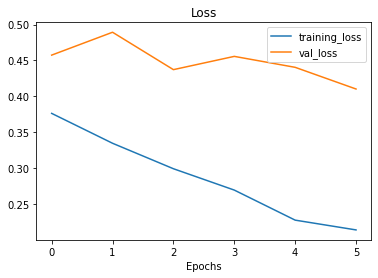

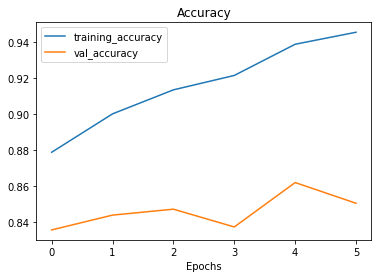

In [168]:
# Check out the loss curves of our fine-tuned model
plot_loss_curves(history_fine_tune_10_percent_data_aug)


# Epochs :
# 0 -> 5 (initial_epoch)
# 1 -> 6
# 2 -> 7
# 3 -> 8
# 4 -> 9
# 5 -> 10


The `plot_loss_curves` function works great with models which have only been fit once, however, we want something to compare one series of running `fit()` with another (e.g. before and after fine-tuning).

In [222]:
# Let's create a function to compare training histories
def compare_histories(original_history, new_history, initial_epochs=5):
  """
  Compares two TensorFlow History objects.
  """
  # Get original history measurements
  acc = original_history.history["accuracy"]
  loss = original_history.history["loss"]

  val_acc = original_history.history["val_accuracy"]
  val_loss = original_history.history["val_loss"]

  # Combine original history
  total_acc = acc + new_history.history['accuracy']
  total_loss = loss + new_history.history['loss']

  total_val_acc = val_acc + new_history.history["val_accuracy"]
  total_val_loss = val_loss + new_history.history["val_loss"]
  
  # Make plots
  plt.figure(figsize=(10,7))
  plt.subplot(2,1,1)
  plt.plot(total_acc, label="Training Accuracy")
  plt.plot(total_val_acc, label="Val Accuracy")
  plt.plot([initial_epochs-1, initial_epochs-1],plt.ylim(),label="Start Fine Tuning")
  plt.legend(loc="upper left")
  plt.title("Training and validation Accuracy")

  # Plot loss
  plt.figure(figsize=(10,7))
  plt.subplot(2,1,2)
  plt.plot(total_loss, label="Training Loss")
  plt.plot(total_val_loss, label="Val Loss")
  plt.plot([initial_epochs-1, initial_epochs-1],plt.ylim(),label="Start Fine Tuning")
  plt.legend(loc="upper right")
  plt.title("Training and validation Loss")

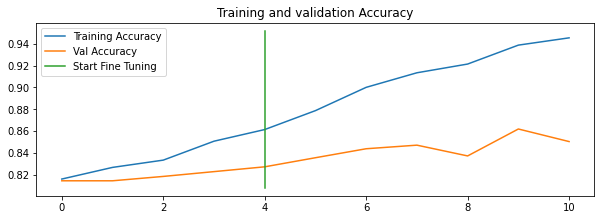

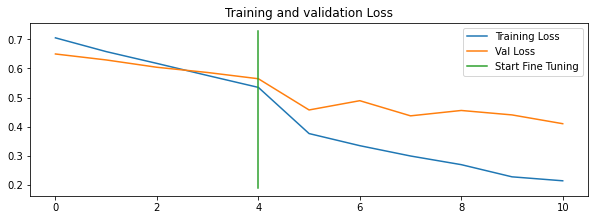

In [223]:
compare_histories(history_2_10_percent_cb, history_fine_tune_10_percent_data_aug)